In [ ]:
## Some Simple GP Work - a Primer
# Felix Weber

In [1]:
import numpy as np
import matplotlib.pyplot as plt

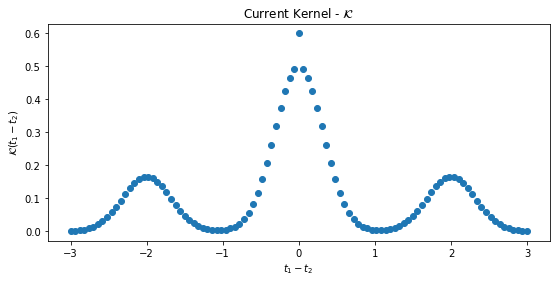

In [800]:
## Creating a Kernel Function

# To work with a gaussian process regression we need to make some assumptions about the underlying process, this is done using a kernel function
# The Kernel function is similar to the autocovariance function of a process and can be thought of as being the same

# In this example we're going to assume a constant measurement uncertainty (i.e. the inherent white-noise process of measurement) for each observation

uncert = 0.1 # inherent measurement uncertainty - This is added only at (t1-t2) = 0
num = 500 # number of time stamps

# Some helper functions

def delta(t1,t2):
    dt = t1-t2
    mask = (dt==0)
    dt[mask] = 1
    dt[~mask] = 0
    return dt

def inv_delta(t1,t2):
    dt = t1-t2
    mask = (dt==0)
    dt[mask] = 0
    dt[~mask] = 1
    return dt

## Now we can choose an appropiate Kernel Function

# This is a gaussian kernel with a simple periodic (2 time units period) behavior

def Kernel(t1,t2):
    return np.exp(- (t1-t2)**2 / 0.2)/2 + uncert*delta(t1,t2) + np.exp( - (np.abs(t1-t2)-2)**2 / 0.2)/6

# This is a sinc kernel that can be often observed in semi-periodic systems

'''def Kernel(t1,t2):
    return uncert*delta(t1,t2) + 2*np.sinc((t1-t2)*1.5) + 1/(np.abs(t1-t2)+1)**2'''

# This is an asymmetric kernel funtion

'''def Kernel(t1,t2):
    return uncert*delta(t1,t2) + 0.5*np.heaviside(t2-t1,1)*np.sinc((t1-t2)) + 0.5*np.heaviside(t1-t2,0.5)/(t1-t2 +1)**4'''

## We can now plot the chosen kernel over t1-t2

plt.figure(figsize=(9,4))
plt.title("Current Kernel - $\mathcal{K}$")
plt.scatter(np.linspace(-3,3,101),Kernel(np.linspace(-3,3,101),0))
plt.xlabel("$t_1 - t_2$")
plt.ylabel("$\mathcal{K}(t_1-t_2)$")
plt.show()

In [804]:
## Define Time coordinates and extract "known" values and relevant covariance matrices

# We can now generate a sample process and "observe" a random number of events in our sample

obs_len = 200  # number of events observed randomly
time_stop = 7  # Don't observe events beyond this time stamp

#------------------------------------------------------------------------

times = np.random.random(num)*10  # Chose a random number of events

times_select = times[times<time_stop][:obs_len]  # Select which events to "observe"
select_indeces = np.where(times<time_stop)[0][:obs_len]
nonselect_indeces = np.setdiff1d(np.linspace(0,num-1,num,dtype=int), select_indeces)
times_nonselect = times[nonselect_indeces]

times2d = np.meshgrid(times,times)

Cov = Kernel(times2d[0],times2d[1])  # Overall covaraiance matrix of all events

Cov11 = Cov[nonselect_indeces][:,nonselect_indeces]  # Covariance matrix of non-observed events
Cov21 = Cov[select_indeces][:,nonselect_indeces]
Cov12 = Cov[nonselect_indeces][:,select_indeces]
Cov22 = Cov[select_indeces][:,select_indeces]  # Covaraiance matrix of observed events

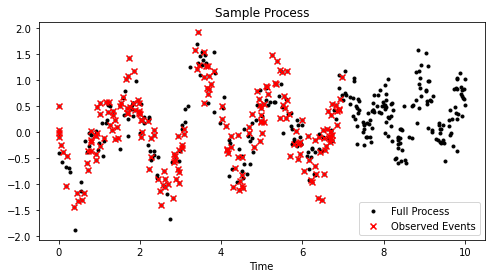

In [805]:
## Generate a sample process

# Using the known covariance matrix, we can randomly generate a sample process, and "observe" some events

Obs_full = np.random.multivariate_normal(np.full(num,0),Cov,size=1)[0]
Obs = Obs_full[select_indeces]  

plt.figure(figsize=(8,4))
plt.title("Sample Process")
plt.scatter(times, Obs_full, color='k',marker='.', label="Full Process")
plt.scatter(times_select, Obs, color='r',marker='x', label="Observed Events")
plt.legend()
plt.xlabel("Time")
plt.show()

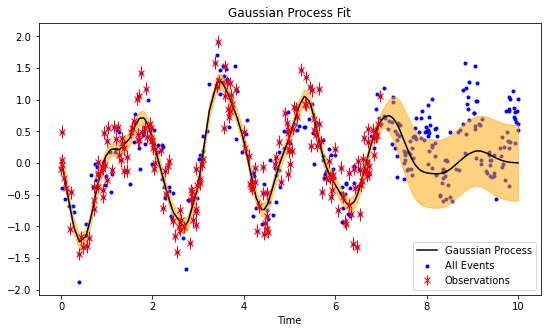

In [806]:
## We can then find the constrained expected values of all non-observed events with some simple linear algebra

mu_p = np.matmul(Cov12, np.matmul(np.linalg.inv(Cov22),Obs))  # Expected non-observed events
Cov_p = Cov11 - np.matmul(Cov12, np.matmul(np.linalg.inv(Cov22),Cov21))  # Expected Covariance of n-O events
sig_p = np.diag(Cov_p)  # Expected uncertainty of the expected n-O events

# Plot Results

plt.figure(figsize=(9,5))
plt.title("Gaussian Process Fit")
plt.errorbar(times_select, Obs, yerr=uncert,color='r', marker='x', label='Observations',zorder=4,lw=0,elinewidth=1)
plt.plot(times_nonselect[np.argsort(times_nonselect)],mu_p[np.argsort(times_nonselect)], color='k',zorder=3, label='Gaussian Process')
plt.fill_between(times_nonselect[np.argsort(times_nonselect)],mu_p[np.argsort(times_nonselect)]+sig_p[np.argsort(times_nonselect)],
                 mu_p[np.argsort(times_nonselect)]-sig_p[np.argsort(times_nonselect)], color='orange', zorder=2,alpha=0.5)
plt.scatter(times, Obs_full, color='b',marker='.', label='All Events')
plt.legend()
plt.xlabel("Time")
plt.show()

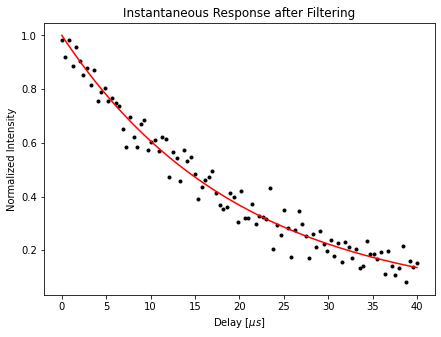

In [840]:
plt.figure(figsize=(7,5))
plt.title("Instantaneous Response after Filtering")
decay = np.exp(-np.linspace(0,40,100)/20)
plt.scatter(np.linspace(0,40,100),decay+np.random.normal(loc=0,scale=1/23,size=100),marker='.',color='k')
plt.plot(np.linspace(0,40,100),decay, c='r')
plt.xlabel("Delay [$\mu s$]")
plt.ylabel("Normalized Intensity")
plt.savefig("InstRespons.png",dpi=150, facecolor='w')
plt.show()